In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import (metrics, linear_model, preprocessing)
import datetime as dt
import math
import matplotlib.pylab as pylab


%matplotlib inline

In [2]:
pylab.rcParams['figure.figsize'] = 10,6
sns.set_style('white')

In [3]:
# Load and combine data
df1 = pd.read_csv('Purchasing Card Data 2014 v1.csv')
df2 = pd.read_csv('PCard Transactions 15-16.csv')
df3 = pd.read_csv('PCard 1617 at Q3.csv')
print(df1.info())
print(df2.info())
print(df3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4142 entries, 0 to 4141
Data columns (total 7 columns):
Service Area           4142 non-null object
Account Description    4142 non-null object
Creditor               4142 non-null object
Transaction Date       4142 non-null object
JV Reference           4142 non-null int64
JV Date                4142 non-null object
JV Value               4142 non-null object
dtypes: int64(1), object(6)
memory usage: 226.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 6 columns):
Service Area           3864 non-null object
Account Description    3864 non-null object
Creditor               3864 non-null object
Journal Date           3864 non-null object
Journal Reference      3864 non-null float64
Total                  3865 non-null object
dtypes: float64(1), object(5)
memory usage: 181.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2890 entries, 0 to 2889
Data columns (total 6 colu

In [4]:
df1_1=df1[['Service Area', 'Account Description', 'Creditor', 'Transaction Date',
       'JV Reference', 'JV Value']]
df1_1=df1_1.rename(columns={'Transaction Date':'Journal Date','JV Reference':'Journal Reference', 'JV Value':'Total'})

In [5]:
frames = [df2,df3,df1_1]
df_combined = pd.concat(frames,axis=0,ignore_index=True)

In [6]:
print(df1_1.shape)
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df_combined.shape)

(4142, 6)
(4142, 7)
(3865, 6)
(2890, 6)
(10897, 6)


In [7]:
#Or create output for incremental load purpose
df_mid = df_combined.copy()
df_mid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10897 entries, 0 to 10896
Data columns (total 6 columns):
Service Area           10894 non-null object
Account Description    10894 non-null object
Creditor               10894 non-null object
Journal Date           10894 non-null object
Journal Reference      10894 non-null float64
Total                  10896 non-null object
dtypes: float64(1), object(5)
memory usage: 510.9+ KB


In [8]:
# Check if date has duplicate
df_mid['Date'] = pd.Series(pd.to_datetime(date) for date in df_mid['Journal Date'])
df_mid.drop('Journal Date',axis=1,inplace=True)

In [9]:
missing = df_mid.isnull().sum()
missing[missing>0]

Service Area           3
Account Description    3
Creditor               3
Journal Reference      3
Total                  1
Date                   3
dtype: int64

In [10]:
df_2 = df_mid.copy()
df_2=df_2.fillna('na')
print(df_2[df_2['Service Area'] == 'na'])

     Service Area Account Description Creditor Journal Reference       Total  \
3864           na                  na       na                na  381,012.77   
6753           na                  na       na                na          na   
6754           na                  na       na                na  312,226.52   

     Date  
3864   na  
6753   na  
6754   na  


In [11]:
# Index 3864, 6753, 6754 data do not make sense, so drop for now
df_mid.drop(df_mid.index[[3864,6753,6754]], inplace=True)
df_mid=df_mid.drop_duplicates(keep='first')
df_mid[df_mid['Total']=='1,107.56']

,Service Area,Account Description,Creditor,Journal Reference,Total,Date
691,Children's Family Services,Miscellaneous Expenses,ARGOS B2B ONLINE,3248.0,"1,107.56",2015-05-28


In [12]:
df_mid.head()

,Service Area,Account Description,Creditor,Journal Reference,Total,Date
0,Assurance,Miscellaneous Expenses,43033820 COSTA COFFEE,5043.0,2,2015-08-18
1,Children's Family Services,Miscellaneous Expenses,99 PLUS DISCOUNT MART,4184.0,29.97,2015-08-06
2,Children's Family Services,E19 - Learning Resources,99P STORES LTD,6278.0,34.65,2015-07-12
3,Children's Family Services,Equipment and Materials Purcha,99P STORES LTD,5041.0,10.72,2015-08-18
4,Children's Family Services,Subsistence,CHOPSTIX00000000000,5750.0,33.7,2015-05-21


In [13]:
df_mid['T2']=df_mid['Total'].apply(lambda x:float(x.replace(',',''))) 
df_mid.drop(['Total'],axis=1,inplace=True)
df_mid.rename(columns={'T2':'Total'},inplace=True)

In [14]:
df_mid['Year'] =  df_mid['Date'].dt.year
df_mid['Qtr'] =  df_mid['Date'].dt.quarter
df_mid['Month'] =  df_mid['Date'].dt.month
df=df_mid
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10891 entries, 0 to 10896
Data columns (total 9 columns):
Service Area           10891 non-null object
Account Description    10891 non-null object
Creditor               10891 non-null object
Journal Reference      10891 non-null float64
Date                   10891 non-null datetime64[ns]
Total                  10891 non-null float64
Year                   10891 non-null int64
Qtr                    10891 non-null int64
Month                  10891 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 850.9+ KB


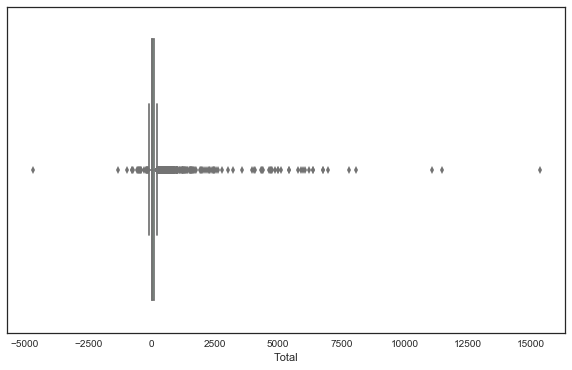

In [15]:
#changes in spending behavior by Service Area and by Account.
sns.boxplot(y='Total', data=df.drop(['Journal Reference','Date'],axis=1),\
            palette='rainbow',orient='h')

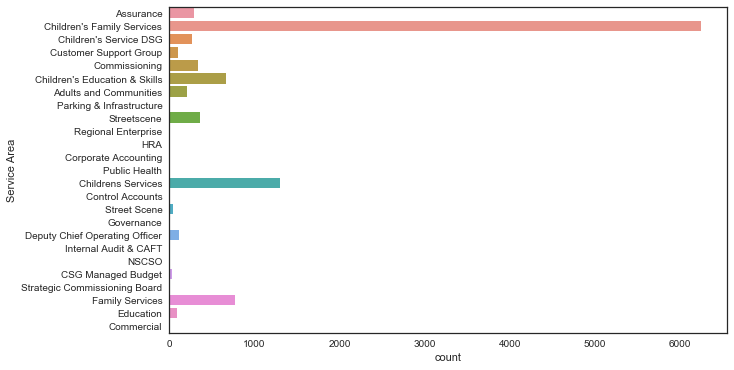

In [16]:
sns.countplot(y='Service Area',data=df,orient='v')

In [17]:
new_s=df.groupby(['Service Area'])['Total'].sum()
new_df=pd.DataFrame(new_s).reset_index()
new_df.head()

,Service Area,Total
0,Adults and Communities,37130.10
1,Assurance,18584.46
2,CSG Managed Budget,70986.34
3,Children's Education & Skills,64736.48
4,Children's Family Services,413870.84


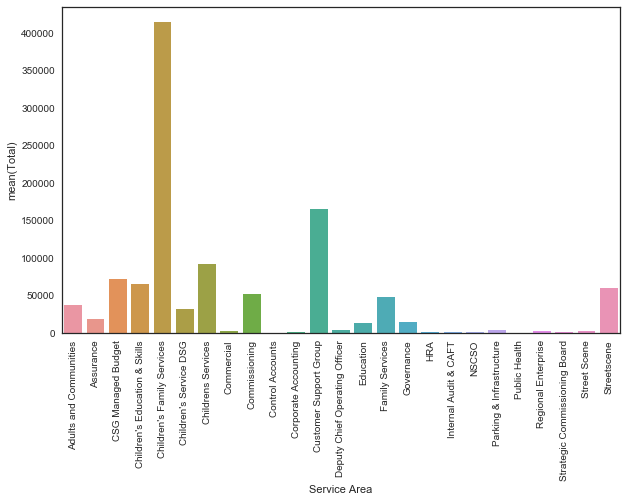

In [18]:
g=sns.barplot(x='Service Area',y='Total', data=new_df,orient='v')
g.set_xticklabels(labels = new_df["Service Area"],rotation=90)

In [255]:
arrays = tuple(set(zip(df.Year, df.Qtr)))
TimeQtrIndex = pd.MultiIndex.from_tuples(arrays,names=['Year','Qtr'])
TimeQtrIndex

MultiIndex(levels=[[2014, 2015, 2016], [1, 2, 3, 4]],
           labels=[[2, 0, 1, 0, 0, 1, 2, 0, 1, 2, 2, 1], [0, 0, 3, 2, 1, 1, 3, 3, 2, 2, 1, 0]],
           names=['Year', 'Qtr'])

In [256]:
# summary view of the transactions for each Service Area
df_copy = df.copy()
df_copy_frame = df_copy.groupby(['Year','Qtr','Account Description'])['Total'].agg(['count','mean'])
df_copy_frame.T.stack()

Year                                         2014                          \
Qtr                                             1           2           3   
      Account Description                                                   
count Advertising                             NaN    8.000000    3.000000   
      Advertising for staff                   NaN         NaN         NaN   
      Books-CDs-Audio-Video             25.000000   50.000000   43.000000   
      Building Repairs & Maintenance     9.000000  144.000000   40.000000   
      Catering Recharge                       NaN         NaN         NaN   
      Cleaning and domestic material    20.000000   45.000000   53.000000   
      Clothing - Protective Clothing          NaN    1.000000    1.000000   
      Clothing - Uniforms                     NaN         NaN    2.000000   
      Conference Expenses                     NaN    1.000000         NaN   
      Consultants Fees                        NaN         NaN         NaN   
      Consumable Catering Supplies       3.000000    5.000000    8.000000   
      Counsels Fees                           NaN         NaN         NaN   
      E19 - Learning Resources                NaN         NaN         NaN   
      E25 - Catering Supplies                 NaN         NaN         NaN   
      Education CFR Administrative S          NaN         NaN         NaN   
      Education CFR Other Occupation          NaN         NaN         NaN   
      Electricity                             NaN         NaN         NaN   
      Employer's National Insurance           NaN         NaN         NaN   
      Equipment Hire                          NaN         NaN         NaN   
      Equipment and Materials Purcha   101.000000  212.000000  221.000000   
      Equipment and Materials Repair     2.000000    1.000000    2.000000   
      Fees and Charges                        NaN         NaN         NaN   
      Fixtures and fittings                   NaN         NaN         NaN   
      Food Costs                        54.000000  172.000000  196.000000   
      Furniture-Purchase-Repair               NaN         NaN         NaN   
      Gas                                     NaN         NaN         NaN   
      General Office Expenses                 NaN    1.000000         NaN   
      Grant Payments                          NaN         NaN         NaN   
      Grounds maintenance                1.000000    2.000000    2.000000   
      Hardware Purchases                      NaN         NaN         NaN   
...                                           ...         ...         ...   
mean  Non Education Staff GPay                NaN         NaN         NaN   
      Operating Leases - Transport            NaN         NaN         NaN   
      Other Agencies - Third Party P          NaN         NaN         NaN   
      Other Energy                            NaN         NaN         NaN   
      Other Establishments - Third P          NaN         NaN         NaN   
      Other Indirect Employee Expens          NaN   40.000000   20.460000   
      Other Services                  1219.048333  559.778889  109.614500   
      Other Transfer Payments to Soc    31.939444   61.972424   64.141273   
      Other Vehicle Costs                     NaN  534.450000         NaN   
      Parking Permit Fees                     NaN         NaN         NaN   
      Pool Transport Charges                  NaN         NaN         NaN   
      Postage                           15.974000  168.726364   97.762353   
      Printing-Contract                       NaN         NaN         NaN   
      Private Contractors - Third Pa   121.122000  116.214444  134.606296   
      Professional Services            620.525000  144.970000  133.166667   
      Publications                       0.550000   46.550000   67.037500   
      Rents                                   NaN         NaN         NaN   
      Software Licences & Support             NaN   94.500000         NaN

In [259]:
df_copy_avg_mean = df_copy.groupby(['Year','Account Description'])['Total'].agg(['count','mean'])

In [260]:
ad_cnt = pd.DataFrame(df_copy['Account Description'].value_counts())
ad_mean = pd.DataFrame(pd.Series(df_copy.groupby('Account Description')['Total'].sum()))
ad_df = pd.concat([ad_cnt,ad_mean],axis=1)
ad_df.rename(columns={'Account Description':'Count','Total':'Average'},inplace=True)
ad_df

,Count,Average
Advertising,26,6083.48
Advertising for staff,1,450.00
Books-CDs-Audio-Video,412,23338.54
Building Repairs & Maintenance,399,18345.96
Catering Recharge,1,100.00
Cleaning and domestic material,613,19906.23
Clothing - Protective Clothing,11,540.87
Clothing - Uniforms,2,107.50
Conference Expenses,29,9362.37
Consultants Fees,2,960.00


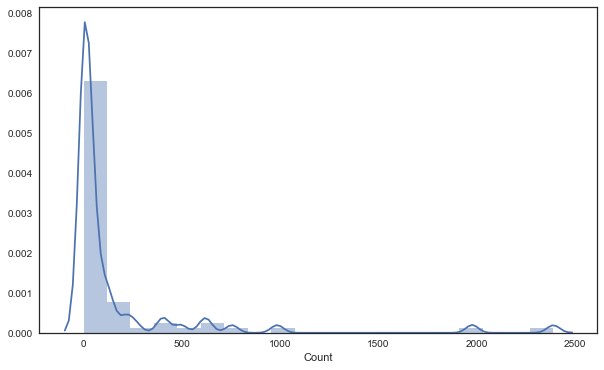

In [261]:
#plt.figure(figsize=(10, 6))
sns.distplot(ad_df['Count'],bins=20)

In [182]:
C=np.corrcoef(ad_df.Count, ad_df.Average)             # calculate correlation matrix
np.round(C[1, 0],3)

0.78200000000000003

In [19]:
#Service Areas that behave similarly and can be grouped together
df.head()

,Service Area,Account Description,Creditor,Journal Reference,Date,Total,Year,Qtr,Month
0,Assurance,Miscellaneous Expenses,43033820 COSTA COFFEE,5043.0,2015-08-18,2.00,2015,3,8
1,Children's Family Services,Miscellaneous Expenses,99 PLUS DISCOUNT MART,4184.0,2015-08-06,29.97,2015,3,8
2,Children's Family Services,E19 - Learning Resources,99P STORES LTD,6278.0,2015-07-12,34.65,2015,3,7
3,Children's Family Services,Equipment and Materials Purcha,99P STORES LTD,5041.0,2015-08-18,10.72,2015,3,8
4,Children's Family Services,Subsistence,CHOPSTIX00000000000,5750.0,2015-05-21,33.70,2015,2,5


In [204]:
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from scipy import stats
import matplotlib.font_manager

In [313]:
outliers_fraction = 0.025

In [314]:
#get dummies
df_sa=pd.get_dummies(df['Service Area'])
df_ad=pd.get_dummies(df['Account Description'])
#df_creditor=pd.get_dummies(df['Creditor'])
#df_jr=pd.get_dummies(df['Journal Reference'])
df_total=df['Total']

In [315]:
#dfm_account=pd.concat([df_ad,df_total],axis=1)
dfm_account=df[['Journal Reference','Total']]
#dfm_account=df[['Account Description','Total']]

In [316]:
dfm_account.head()

,Journal Reference,Total
0,5043.0,2.00
1,4184.0,29.97
2,6278.0,34.65
3,5041.0,10.72
4,5750.0,33.70


In [317]:
classifiers={"One-Class SVM":svm.OneClassSVM(nu=0.9*outliers_fraction+0.01,kernel='rbf',gamma=0.1),\
            "robust covariance estimator":EllipticEnvelope(contamination=0.1)}

In [318]:
for i,(clf_name,clf) in enumerate(classifiers.items()):
    print(clf_name)
    clf.fit(dfm_account)
    y_pred=clf.decision_function(dfm_account)
    print(y_pred[:10],y_pred.shape)
    threhold=stats.scoreatpercentile(y_pred, 100*outliers_fraction)
    y_pred=y_pred>threhold
    print(y_pred.sum())
# check how many normal data    

One-Class SVM
[[  8.10402731e-05]
 [  4.09452928e-04]
 [ -5.08049893e-05]
 [  9.02820236e-05]
 [ -8.87015010e-05]
 [ -4.60446333e-05]
 [ -1.20871759e-04]
 [ -1.17991361e-04]
 [ -2.53299504e-04]
 [  4.23381809e-04]] (10891, 1)
10618
robust covariance estimator
0    4.650808
1    4.747406
2    4.575684
3    5.075386
4    4.640356
5    5.000118
6    4.200729
7    3.147832
8    1.558572
9    4.025866
dtype: float64 (10891,)
10618


In [319]:
print(len(y_pred))
indices=[i for i in range(y_pred.size)]
indices[:5]

10891


[0, 1, 2, 3, 4]

In [320]:
ind=list(y_pred[y_pred==False].index)
#ind = [j for j in indices if y_pred[j] == False] 
print('Outliers total is ' + str(len(ind)))
print(ind)

Outliers total is 273
[39, 88, 94, 95, 559, 684, 691, 692, 698, 736, 751, 752, 753, 1260, 1272, 1288, 1368, 1374, 1394, 1395, 1396, 1488, 1490, 1505, 1547, 1563, 1568, 1571, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1594, 1595, 1598, 1599, 1652, 1730, 1820, 1824, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1874, 1875, 1876, 1889, 1895, 1952, 1999, 2208, 2210, 2226, 2242, 2243, 2251, 2290, 2294, 2295, 2324, 2340, 2344, 2850, 2853, 3203, 3402, 3403, 3408, 3434, 3452, 3509, 3532, 3556, 3732, 3733, 3748, 3778, 3820, 3936, 3963, 3982, 4013, 4205, 4207, 4212, 4216, 4218, 4343, 4346, 4350, 5313, 5350, 5364, 5377, 5414, 5418, 5470, 5471, 5522, 5524, 5525, 5526, 5582, 5588, 5589, 5605, 5607, 5610, 5611, 5621, 5623, 5655, 5656, 5657, 5707, 5711, 5783, 5786, 5790, 5793, 5818, 5830, 5844, 5845, 5859, 5991, 5992, 5993, 6018, 6023, 6024, 6071, 6089, 6090, 6091, 6196, 6216, 6226, 6249, 6412, 6413, 6415, 6420, 6423, 6425, 6426, 6427, 6428, 6429, 6430, 6431, 6432, 6433, 6434, 6435, 6437, 6438

In [321]:
pred_df=pd.DataFrame(y_pred)
pred_df.columns=['Normal Data']

In [322]:
# Label the data set
data = pd.concat([df,pred_df],axis=1)

In [323]:
data.head()

,Service Area,Account Description,Creditor,Journal Reference,Date,Total,Year,Qtr,Month,Normal Data
0,Assurance,Miscellaneous Expenses,43033820 COSTA COFFEE,5043.0,2015-08-18,2.00,2015,3,8,True
1,Children's Family Services,Miscellaneous Expenses,99 PLUS DISCOUNT MART,4184.0,2015-08-06,29.97,2015,3,8,True
2,Children's Family Services,E19 - Learning Resources,99P STORES LTD,6278.0,2015-07-12,34.65,2015,3,7,True
3,Children's Family Services,Equipment and Materials Purcha,99P STORES LTD,5041.0,2015-08-18,10.72,2015,3,8,True
4,Children's Family Services,Subsistence,CHOPSTIX00000000000,5750.0,2015-05-21,33.70,2015,2,5,True
